In [1]:
import os
import cv2
import math
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
Veh_Imgs_Path = "./../udacity_dataset/vehicles/vehicles/"
NonVeh_Imgs_Path = "./../udacity_dataset/non_vehicles/non_vehicles/"

Veh_Imgs = os.listdir(Veh_Imgs_Path)
NonVeh_Imgs = os.listdir(NonVeh_Imgs_Path)

In [3]:
def CollectImages(folderpath, ImagePaths, isLabeled = True):
    images = []
    for ImagePath in ImagePaths:
        if (len(ImagePath.split('.')) == 2):
            im = cv2.imread(folderpath + ImagePath)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            #print('Image ' , ImagePath , ' is: ', type(im), ' with dimensions: ', im.shape)
            if isLabeled == True:
                images.append((im, ImagePath.split('.')[0]))
            else:
                images.append(im)
        else:
            print('Image', ImagePath, 'is correupted --> Discarded.')

    return images

In [4]:
CarImageSet = []
NonCarImageSet = []

for folder in Veh_Imgs:
    folderpath = Veh_Imgs_Path + folder
    Carsimagespath = os.listdir(folderpath)
    CarImageSet.append(CollectImages(folderpath + '/', Carsimagespath, True))

for folder in NonVeh_Imgs:
    folderpath = NonVeh_Imgs_Path + folder
    NonCarsimagespath = os.listdir(folderpath)
    NonCarImageSet.append(CollectImages(folderpath + '/', NonCarsimagespath, True))

CarImageSet = np.concatenate(CarImageSet)
NonCarImageSet = np.concatenate(NonCarImageSet)

print('Car Image Set has ', str(len(CarImageSet)))
print('Non Car Image Set has ', str(len(NonCarImageSet)))

Car Image Set has  8792
Non Car Image Set has  8968


In [5]:
def pltImages(images, labels, nrows = 1, ncols = 2, fig_w = 20, fig_h = 10, isgray = False):
    #below code is inspired from https://stackoverflow.com/questions/17111525/how-to-show-multiple-images-in-one-figure
    assert len(images) == len(labels)
    assert len(images) <= (nrows * ncols)
    
    fig = plt.figure(figsize=(fig_w, fig_h))
    
    for index in range(len(images)):
        plot = fig.add_subplot(nrows,ncols,index+1)
        plot.set_title(labels[index])
        if(isgray == False):
            plt.imshow(images[index].squeeze())
        else:
            plt.imshow(images[index].squeeze(), cmap='gray')
    
    plt.tight_layout()
    plt.show()

In [6]:
def pltHistograms(hists, labels, nrows = 1, ncols = 2, fig_w = 20, fig_h = 10, xlim = [0,256]):
    assert len(hists) == len(labels)
    assert len(hists) <= (nrows * ncols)
    
    fig = plt.figure(figsize=(fig_w, fig_h))
    
    for index in range(len(hists)):
        plot = fig.add_subplot(nrows,ncols,index+1)
        plot.set_title(labels[index])
        plt.plot(hists[index])
        plt.xlim(xlim)
    
    plt.tight_layout()
    plt.show()

In [7]:
imgPxlVal = 0
img_Label = 1

Channel_0 = 0
Channel_1 = 1
Channel_2 = 2

histSize = [48]
histrange = [0,255]

ColorSpace = ['RGB','HSV','HLS', 'LAB', 'YUV', 'LUV', 'YCrCb']

In [8]:
def ExploreColorSpaceHistogram(img):
    hist = []
    hist_label = []

    hist_0 = cv2.calcHist(img,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(img,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(img,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("RGB_Channel 0")
    hist.append(hist_1)
    hist_label.append("RGB_Channel 1")
    hist.append(hist_2)
    hist_label.append("RGB_Channel 2")

    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    hist_0 = cv2.calcHist(HSV,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(HSV,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(HSV,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("HSV_Channel 0")
    hist.append(hist_1)
    hist_label.append("HSV_Channel 1")
    hist.append(hist_2)
    hist_label.append("HSV_Channel 2")

    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    hist_0 = cv2.calcHist(HLS,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(HLS,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(HLS,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("HLS_Channel 0")
    hist.append(hist_1)
    hist_label.append("HLS_Channel 1")
    hist.append(hist_2)
    hist_label.append("HLS_Channel 2")

    LAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    hist_0 = cv2.calcHist(LAB,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(LAB,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(LAB,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("LAB_Channel 0")
    hist.append(hist_1)
    hist_label.append("LAB_Channel 1")
    hist.append(hist_2)
    hist_label.append("LAB_Channel 2")

    YUV = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    hist_0 = cv2.calcHist(YUV,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(YUV,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(YUV,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("YUV_Channel 0")
    hist.append(hist_1)
    hist_label.append("YUV_Channel 1")
    hist.append(hist_2)
    hist_label.append("YUV_Channel 2")

    LUV = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

    hist_0 = cv2.calcHist(LUV,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(LUV,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(LUV,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("LUV_Channel 0")
    hist.append(hist_1)
    hist_label.append("LUV_Channel 1")
    hist.append(hist_2)
    hist_label.append("LUV_Channel 2")
    
    YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    hist_0 = cv2.calcHist(YCrCb,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(YCrCb,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(YCrCb,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("YCrCb_Channel 0")
    hist.append(hist_1)
    hist_label.append("YCrCb_Channel 1")
    hist.append(hist_2)
    hist_label.append("YCrCb_Channel 2")

    pltHistograms(hist, hist_label, 7, 3, xlim = [0, histSize[0]-1])

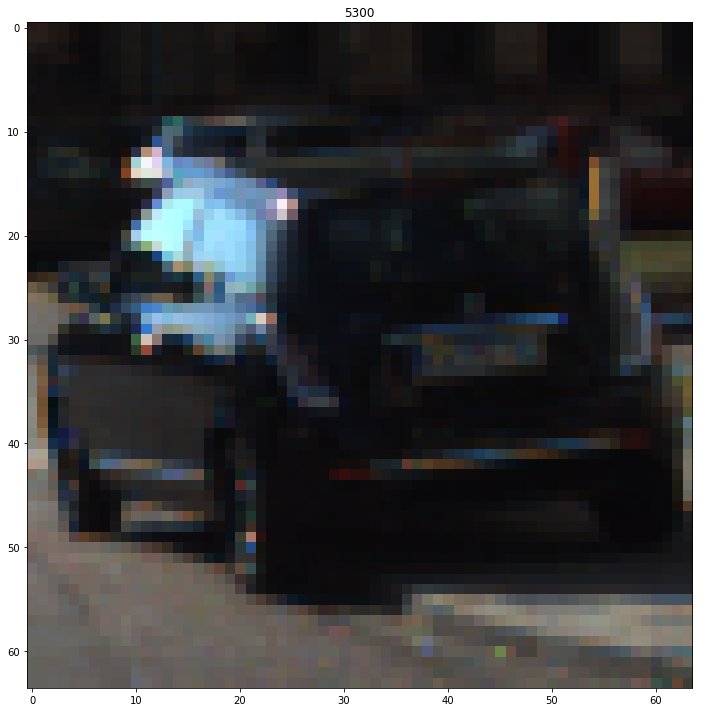

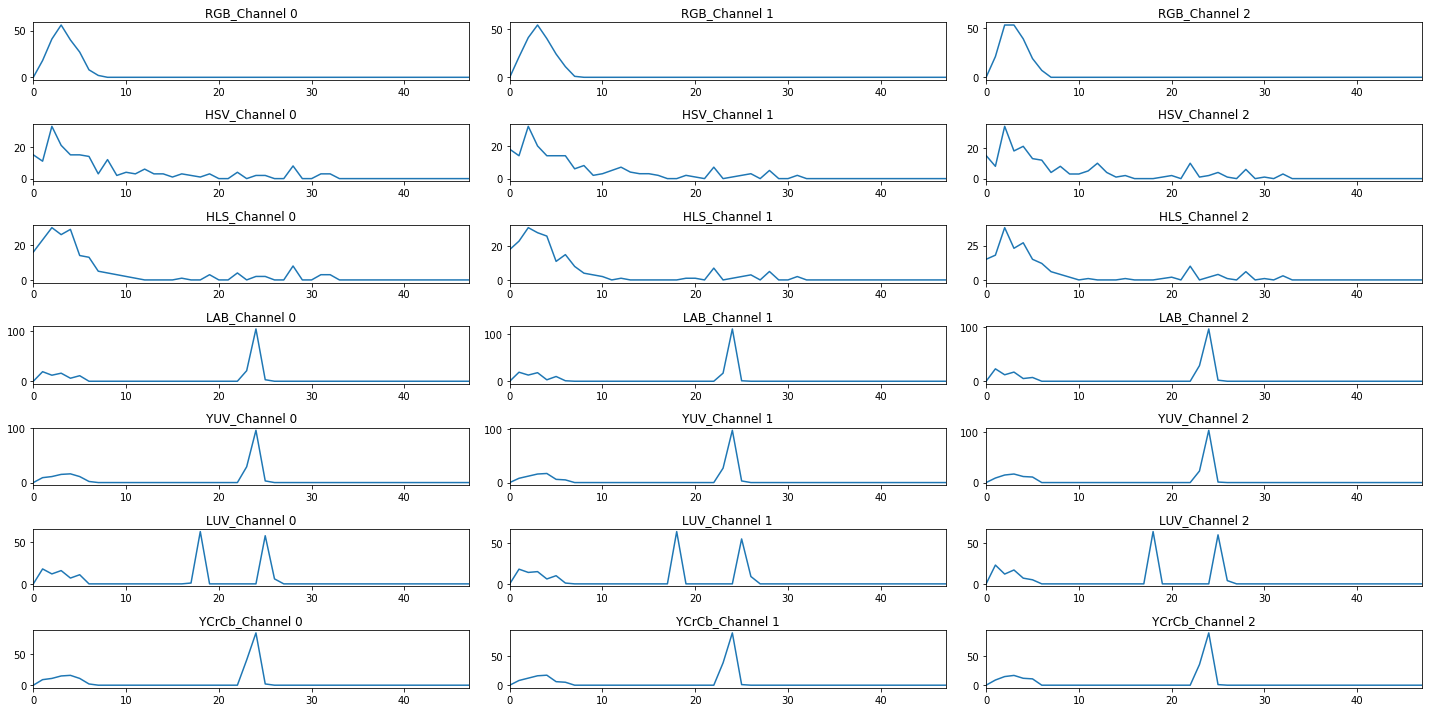

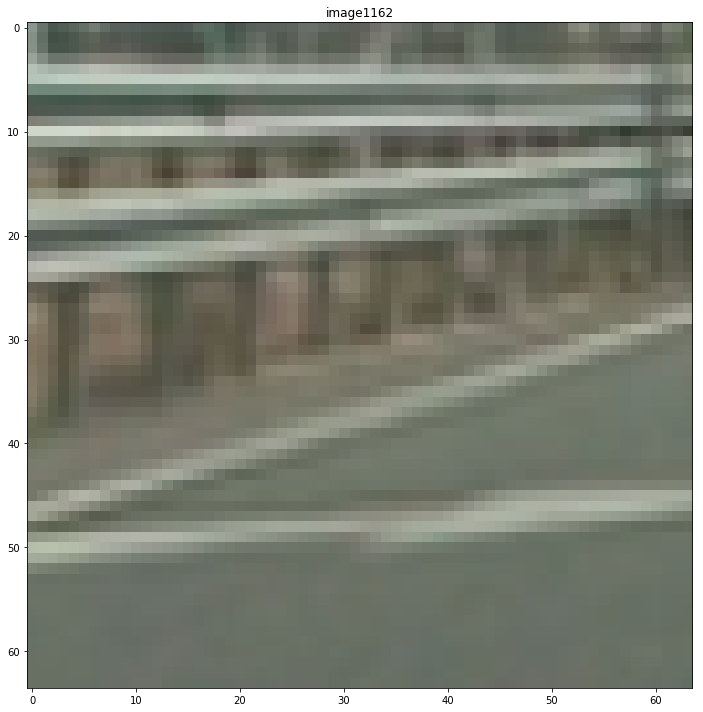

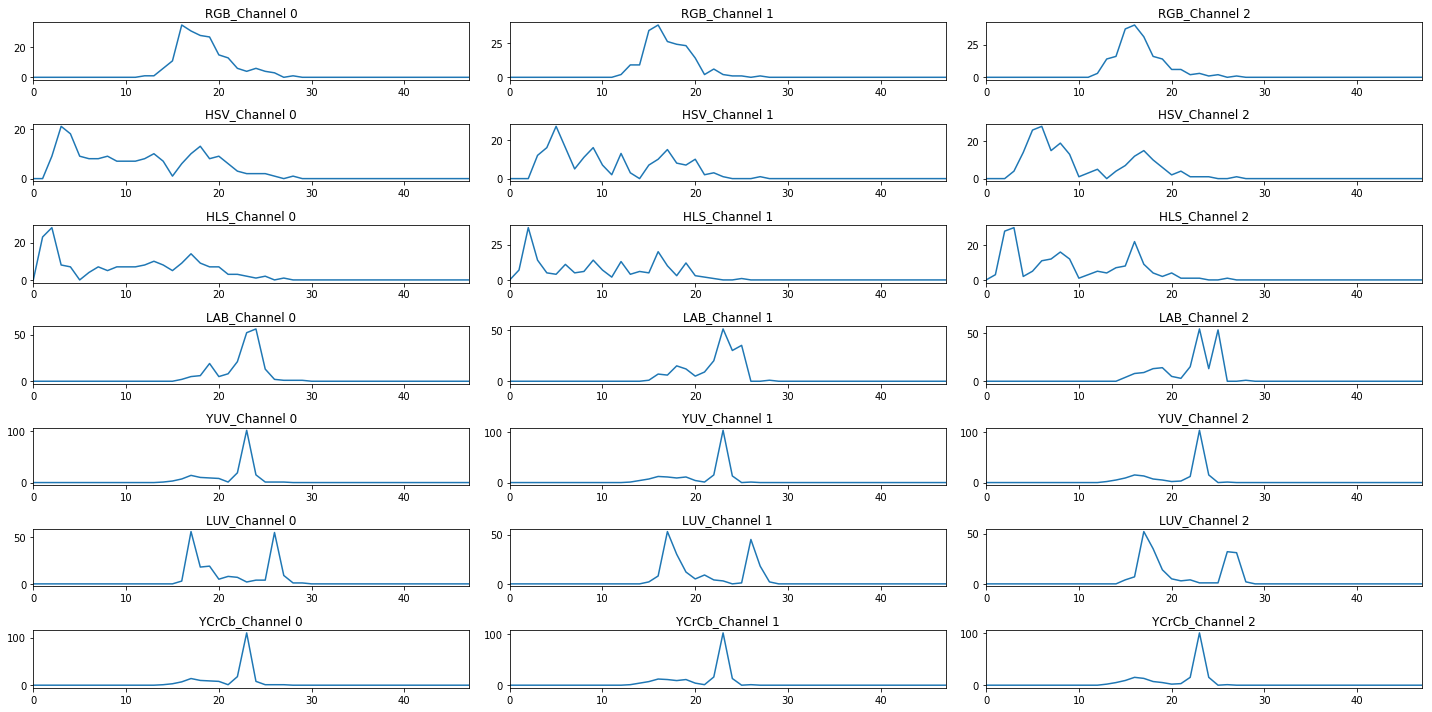

In [9]:
#CarImageIndex = 0
CarImageIndex = randint(0, len(CarImageSet))
CarImage = [CarImageSet[CarImageIndex][imgPxlVal]]
CarImageLavel = [CarImageSet[CarImageIndex][img_Label]]

pltImages(CarImage, CarImageLavel, 1, 1)
ExploreColorSpaceHistogram(CarImage[0])

#NonCarImageIndex = 0
NonCarImageIndex = randint(0, len(NonCarImageSet))
NonCarImage = [NonCarImageSet[NonCarImageIndex][imgPxlVal]]
NonCarImageLavel = [NonCarImageSet[NonCarImageIndex][img_Label]]

pltImages(NonCarImage, NonCarImageLavel, 1, 1)
ExploreColorSpaceHistogram(NonCarImage[0])